/home/nitishdumoliya/miniconda3/envs/water/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The license for this AMPL processor will expire in 1.6 days.


Water Network: d4_double_hanoi 



NetworkXError: Node 33 has no position.

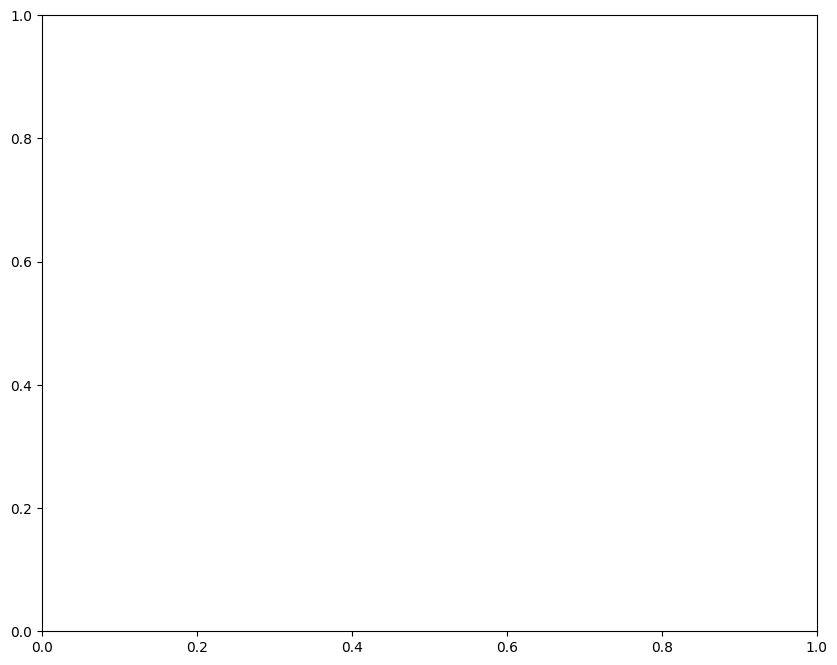

In [1]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from tabulate import tabulate
import optuna
import warnings
warnings.filterwarnings("ignore")
from pyswarm import pso
import multiprocessing

from network_layout import node_position
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.path import Path

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number, data_list):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_list = data_list
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        self.best_acyclic_flow = None
        self.number_of_nlp = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
        self.L = self.ampl.getParameter('L').to_dict()
        self.D = self.ampl.getParameter('D').to_dict()
        self.C = self.ampl.getParameter('C').to_dict()
        self.P = self.ampl.getParameter('P').to_dict()
        self.R = self.ampl.getParameter('R').to_dict()
        self.E = self.ampl.getParameter('E').to_dict()
        self.d = self.ampl.getParameter('d').to_dict()
        #self.eps = self.ampl.getParameter('eps').to_list()[0]
        
        
        self.delta = 0.1
        self.p = 1.852
        self.omega = 10.67
    
    def plot_graph1(self):
        pos = node_position[self.data_number]
        cost = {}

        # for (i, j) in self.ampl.getSet('arcs'):
        #     cost[i, j] = sum(l[i, j, k] * C[k] for k in self.ampl.getSet('pipes'))

        plt.figure(figsize=(8, 6))
        cmap = plt.cm.plasma

        source = list(self.ampl.getSet('Source'))
        draw_nodes = [n for n in self.network_graph.nodes if n not in source]

        # === Draw regular nodes (excluding source node) ===
        # nx.draw_networkx_nodes(self.network_graph, pos, nodelist=draw_nodes, node_color='lightblue', edgecolors="black", node_size=200, linewidths=1, label='Regular Nodes')

        # === Draw labels for regular nodes only ===
        # nx.draw_networkx_labels(self.network_graph, pos, font_size=9, labels={n: n for n in draw_nodes})
        # nx.draw_networkx_labels(self.network_graph, pos, font_size=5)
#         if source:
#             nx.draw_networkx_nodes(self.network_graph, pos, nodelist=source, node_color='cornflowerblue',edgecolors="black", node_size=200,linewidths=0.5, label='Visited nodes')
            
        # === Draw regular edges (exclude arcs from source nodes) ===
        # regular_edges = [(i, j) for (i, j) in self.network_graph.edges if i not in source]
        # nx.draw_networkx_edges(self.network_graph, pos, edgelist=self.network_graph.edges, arrowstyle="->", arrowsize=12, edge_color='black', arrows=False)

        # === Draw tanks and custom outgoing arcs ===
        for s_node in source:
            if s_node not in pos:
                continue

            tank_width, tank_height = 500, 500
            tank_center = pos[s_node]
            tank_x = tank_center[0] 
            tank_y = tank_center[1] 

            # Water (lower half)
            water_height = tank_height / 2
            water_fill = Rectangle((tank_x, tank_y), tank_width, water_height, linewidth=0, edgecolor=None, facecolor='cornflowerblue', zorder=4)
            plt.gca().add_patch(water_fill)

            # Tank outline
            left_line = Line2D([tank_x, tank_x], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=5)
            right_line = Line2D([tank_x + tank_width, tank_x + tank_width], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=5)
            bottom_line = Line2D([tank_x, tank_x + tank_width], [tank_y, tank_y], color='black', linewidth=1.5, zorder=5)
            plt.gca().add_line(left_line)
            plt.gca().add_line(right_line)
            plt.gca().add_line(bottom_line)

#             # Optional: label near tank, not between tank and arc
            plt.text(tank_x + 100, tank_y - 300 , f"{s_node}", fontsize=10, ha='center', va='center', color='black', zorder=6)
            plt.text(tank_x+1000, tank_y   , "Reservoir", fontsize=10, ha='center', va='center', color='black', zorder=6)
        if source:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=source, node_color='cornflowerblue',edgecolors="black", node_size=200,linewidths=0.5, label='Visited nodes')
        nx.draw_networkx_labels(self.network_graph, pos, font_size=9, labels={n: n for n in self.network_graph.nodes})
        nx.draw_networkx_nodes(self.network_graph, pos, nodelist=draw_nodes, node_color='lightblue', edgecolors="black", node_size=200, linewidths=1, label='Regular Nodes')
        nx.draw_networkx_edges(self.network_graph, pos, edgelist=self.network_graph.edges, arrowstyle="->", arrowsize=12, edge_color='black', arrows=False)
        # === Save and display ===
        plt.box(False)
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/wdnd/figure/d{self.data_number + 1}.pdf", format="pdf", dpi=1000, bbox_inches="tight")
        plt.show()

    def plot_graph(self):
        pos = node_position[self.data_number]
        pos11 = {
              1:  (1200.0, 6900.0),
                2:  (8700.0, 5200.0),
                3:  (1000.0, 6300.0),
                4:  (900.0, 5500.0),
                5:  (2500.0, 6000.0),
                6:  (4000.0, 6000.0),
                7:  (5000.0, 6000.0),
                8:  (6300.0, 5500.0),
                9:  (850.0, 4800.0),
                10: (2000.0, 4800.0),
                11: (3000.0, 4800.0),
                12: (4000.0, 4800.0),
                13: (5000.0, 4800.0),
                14: (7200.0, 4800.0),
                15: (800.0, 4200.0),
                16: (5500.0, 3800.0),
                17: (8000.0, 3800.0),
                18: (800.0, 3500.0),
                19: (2000.0, 3500.0),
                20: (4000.0, 3500.0),
                21: (6000.0, 3000.0),
                22: (8000.0, 2800.0),
                23: (1200.0, 2500.0),
                24: (3000.0, 1700.0),
                25: (5000.0, 1800.0),
                26: (6800.0, 2000.0)
            }

        cost = {}

        plt.figure(figsize=(10, 8))
        cmap = plt.cm.plasma

        source = list(self.ampl.getSet('Source'))
        draw_nodes = [n for n in self.network_graph.nodes if n not in source]

        # === Draw regular nodes (excluding source node) ===
        nx.draw_networkx_nodes(self.network_graph, pos, nodelist=draw_nodes, node_color='lightblue',
                               edgecolors="black", node_size=200, linewidths=1, label='Regular Nodes')

        # === Draw labels for regular nodes only ===
        nx.draw_networkx_labels(self.network_graph, pos, font_size=9, labels={n: n for n in draw_nodes})
        # === Draw all edges ===
        nx.draw_networkx_edges(self.network_graph, pos, edgelist=self.network_graph.edges,
                               arrowstyle="->", arrowsize=12, edge_color='black', arrows=False)

        # === Draw tanks (reservoirs) behind source nodes ===
        for s_node in source:
            if s_node not in pos:
                continue
            tank_center = pos[s_node]
            tank_width, tank_height = 300, 300
            water_height = tank_height / 2

            # Align tank center with source node center
            tank_x = tank_center[0] 
            tank_y = tank_center[1] 

            # Draw water (lower half of tank)
            water_fill = Rectangle((tank_x, tank_y), tank_width, water_height+5,
                                   linewidth=0, edgecolor=None, facecolor='cornflowerblue', zorder=0)
            plt.gca().add_patch(water_fill)

            # Tank outline (behind the node)
            left_line = Line2D([tank_x, tank_x], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=0)
            right_line = Line2D([tank_x + tank_width, tank_x + tank_width], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=0)
            bottom_line = Line2D([tank_x, tank_x + tank_width], [tank_y, tank_y], color='black', linewidth=1.5, zorder=0)

            plt.gca().add_line(left_line)
            plt.gca().add_line(right_line)
            plt.gca().add_line(bottom_line)

            # Reservoir label (slightly below the tank)
            plt.text(tank_center[0]+500, tank_y - 80, "Reservoir",
                     fontsize=9, ha='center', va='top', color='black', zorder=1)

        # === Draw source nodes (after tank so node is on top) ===
        if source:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=source, node_color='cornflowerblue',
                                   edgecolors="black", node_size=200, linewidths=0.5, label='Source Nodes')
            nx.draw_networkx_labels(self.network_graph, pos, font_size=6, labels={n: n for n in source})

        # === Finalize and save ===
        plt.box(False)
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/wdnd/figure/d{self.data_number + 1}.pdf",
                    format="pdf", dpi=1000, bbox_inches="tight")
        plt.show()      
    def generate_random_acyclic_from_solution(self, q):
        # print("Generate the acyclic network using ipopt solution")
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(self.nodes)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in self.arcs:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)
        
        return self.network_graph
        
    def run(self):
        """Main method to run the optimization process."""
        
        self.start_time = time.time()
        
        self.bound_push , self.bound_frac = (0.001, 0.001)
         
        self.load_model()
            
        self.l = self.ampl.getVariable('l').getValues().to_dict()
        self.q = self.ampl.getVariable('q').getValues().to_dict()
        self.h = self.ampl.getVariable('h').getValues().to_dict()
        self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        self.plot_graph()
        elapsed_time = time.time() - self.start_time   

if __name__ == "__main__":
    data_list = [
        "d1_bessa",
        "d2_shamir",
        "d3_hanoi",
        "d4_double_hanoi",
        "d5_triple_hanoi",
        "d6_newyork",
        "d7_blacksburg",
        "d8_fossolo_iron",
        "d9_fossolo_poly_0",
        "d10_fossolo_poly_1",
        "d11_kadu",
        "d12_pescara",
        "d13_modena",
        "d14_balerma",
    ]

    data_number = 4 - 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/wdnd/data/{data_list[(data_number)]}.dat"
    print("Water Network:", data_list[(data_number)],"\n")
    optimizer = WaterNetworkOptimizer("wdnmodel.mod", input_data_file, data_number, data_list)
    # optimizer = WaterNetworkOptimizer("newyork_model.mod", input_data_file, data_number, data_list)
    # optimizer = WaterNetworkOptimizer("blacksburg_model.mod", input_data_file, data_number, data_list)
    optimizer.run()